In [1]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

tfd = tfp.distributions
tfm = tf.math
tf.config.list_physical_devices(device_type=None)

2022-11-21 14:50:46.177359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/system/CUDA/11.0.2/nvvm/lib64:/opt/apps/software/system/CUDA/11.0.2/extras/CUPTI/lib64:/opt/apps/software/system/CUDA/11.0.2/lib:/opt/apps/software/lib/slurm-drmaa/1.1.3/lib:/opt/apps/software/lib/libevent/2.1.8/lib:/opt/apps/software/devel/PCRE/8.41-GCCcore-7.3.0/lib:/opt/apps/software/lang/Perl/5.28.0-GCCcore-7.3.0/lib:/opt/apps/software/tools/expat/2.2.5-GCCcore-7.3.0/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib/python2.7/site-packages/numpy-1.14.5-py2.7-linux-x86_64.egg/numpy/core/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib64:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib:/opt/apps/software/math/GMP/6.1.2-GCCcore-7.3.0/lib:/opt/apps/so

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
# Configure paths
CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "data"))
OUTPUTS_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "..", "outputs"))

In [3]:
# Load data
with open(DATA_PATH + '/f_boundary.pkl', 'rb') as file:
    f_boundary = pkl.load(file)
    
with open(DATA_PATH + '/p.pkl', 'rb') as file:
    p = pkl.load(file)
    
with open(DATA_PATH + '/T.pkl', 'rb') as file:
    T = pkl.load(file)
    
with open(DATA_PATH + '/r.pkl', 'rb') as file:
    r = pkl.load(file)
    
with open(DATA_PATH + '/P_predict.pkl', 'rb') as file:
    P_predict = pkl.load(file)
    
# Get upper and lower bounds
lb = np.log(np.array([p[0], r[0]], dtype='float32'))
ub = np.log(np.array([p[-1], r[-1]], dtype='float32'))
f_bound = np.array([-34.54346331847909, 6.466899920699378], dtype='float32')
size = len(f_boundary[:, 0])

In [4]:
batchsize = 2048
boundary_batchsize = 512
n_samples = 20000

# Sampling

In [5]:
# Sample p and r according to a beta distribution between upper and lower bounds
beta_dist = tfd.Beta(3, 1)
uniform_dist = tfd.Uniform(0, 1)

p = (uniform_dist.sample((batchsize, 1))*tfm.abs(ub[0] - lb[0])) + lb[0]
p = np.exp(p)
r = (uniform_dist.sample((batchsize, 1))*tfm.abs(np.exp(ub[1]) - np.exp(lb[1]))) + np.exp(lb[1])

p = pd.DataFrame(p[:, 0], columns=['p'])
r = pd.DataFrame(r[:, 0]/150e6, columns=['r'])

2022-11-21 14:51:11.799356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


array([<AxesSubplot:title={'center':'r'}>], dtype=object)

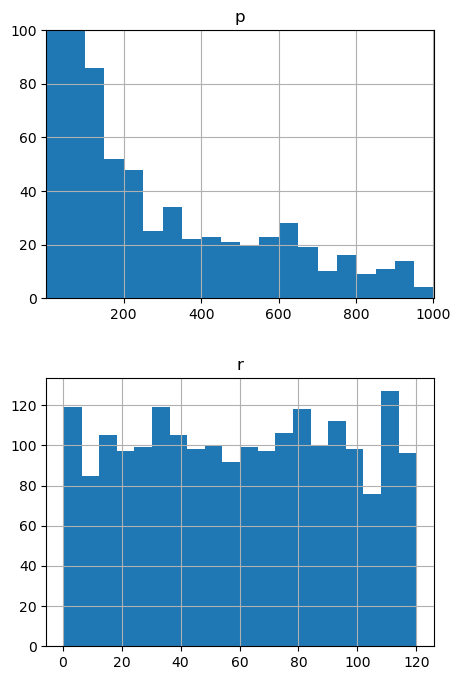

In [6]:
# Visualize
fig, axes = plt.subplots(2, figsize=(5, 8))
axes[0].set_title('p')
p.hist(ax=axes[0], bins=20)
axes[0].set_xlim(4.332436e-02, 1.00093756e+03)
axes[0].set_ylim(0, 100)

axes[1].set_title('r')
r.hist(ax=axes[1], bins=20)
# axes[1].set_xlim(5.9999988e+07, 1.80000010e+10)

In [4]:
# Imports
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

tfd = tfp.distributions
tfm = tf.math
tf.config.list_physical_devices(device_type=None)

CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.abspath(os.path.join(CURRENT_PATH, "data"))

# Constants  
m = 0.938 # GeV/c^2
gamma = -3 # Between -2 and -3
size = 512 # size of r, T, p, and f_boundary
au = 150e6 # 150e6 m/AU
r_limits = [0.4, 120] 
T_limits = [0.001, 1000]

# Create boundary data
T = np.logspace(np.log10(T_limits[0]), np.log10(T_limits[1]), size).flatten()[:, None]
p = (np.sqrt((T+m)**2-m**2)).flatten()[:,None] # GeV/c
r = np.logspace(np.log10(r_limits[0]*au), np.log10(r_limits[1]*au), size).flatten()[:, None] # km
f_boundary = ((T + m)**gamma)/(p**2) # particles/(m^3 (GeV/c)^3)

# Create J
J = np.zeros((size, size))
J_boundary = (f_boundary*(p**2))[:, 0]

# Define phi
def phi_func(r):
    k_0 = 1e11
    func = np.log((120*150e6)/r)*((150e6*400)/(3*k_0))
    return func

# For each r, get phi
for i in range(size):
    phi = phi_func(r[i])
    
    # for each T, calculate J[r, T]
    for j in range(size):
        where_phi = np.argmin(np.abs(T[:, 0] - (T[j, 0] + phi)))
        J[i, j] = ((T[j, 0]*(T[j, 0]+2*m))/((T[j, 0]+phi)*(T[j, 0]+phi+2*m))) * J_boundary[where_phi]

# Scale f_boundary
# f_boundary = np.log(f_boundary)

In [8]:
print(np.min(f_boundary*(p**2)), np.max(f_boundary*(p**2)))
print(np.min(f_boundary), np.max(f_boundary))
f_boundary = np.log(f_boundary)
print(np.min(f_boundary), np.max(f_boundary))

9.971912708226599e-10 1.207822799167287
9.953240429181456e-16 643.4857747295022
-34.54346331847909 6.466899920699378
